In [3]:
!pip install yfinance pandas


In [5]:
import yfinance as yf
import pandas as pd

symbol = "^NSEI"

# Download last 60 days of 5-min data
df = yf.download(symbol, period="60d", interval="5m")

# Remove duplicated index
df = df[~df.index.duplicated()]

# Reset index
df.reset_index(inplace=True)

# Rename columns
df = df.rename(columns={
    "Datetime": "Date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume"
})

# Keep only required columns
df = df[["Date", "open", "high", "low", "close", "volume"]]


[*********************100%***********************]  1 of 1 completed


In [7]:
import pandas as pd

# Load the cleaned Nifty spot CSV
nifty_spot_df = pd.read_csv("nifty_spot_5min.csv", parse_dates=['Date'])
nifty_spot_df.set_index('Date', inplace=True)

print(nifty_spot_df.head())


                                      open             high              low  \
Date                                                                           
NaT                                  ^NSEI            ^NSEI            ^NSEI   
2025-10-24 03:45:00+00:00   25939.30078125   25939.30078125   25846.05078125   
2025-10-24 03:50:00+00:00  25851.150390625  25892.400390625  25840.400390625   
2025-10-24 03:55:00+00:00   25886.30078125   25893.30078125          25859.5   
2025-10-24 04:00:00+00:00  25885.849609375  25887.599609375          25864.5   

                                     close volume  
Date                                               
NaT                                  ^NSEI  ^NSEI  
2025-10-24 03:45:00+00:00   25850.80078125      0  
2025-10-24 03:50:00+00:00          25886.0      0  
2025-10-24 03:55:00+00:00  25886.400390625      0  
2025-10-24 04:00:00+00:00  25875.400390625      0  


In [9]:
import pandas as pd

# Load CSV
nifty_spot_df = pd.read_csv("nifty_spot_5min.csv", parse_dates=['Date'])
nifty_spot_df.set_index('Date', inplace=True)

# Convert numeric columns
for col in ['open', 'high', 'low', 'close', 'volume']:
    nifty_spot_df[col] = pd.to_numeric(nifty_spot_df[col], errors='coerce')  # converts bad values to NaN

# Drop rows where 'close' is NaN (bad data)
nifty_spot_df.dropna(subset=['close'], inplace=True)

# Calculate returns
nifty_spot_df['returns'] = nifty_spot_df['close'].pct_change()

# EMAs
nifty_spot_df['ema_5'] = nifty_spot_df['close'].ewm(span=5, adjust=False).mean()
nifty_spot_df['ema_15'] = nifty_spot_df['close'].ewm(span=15, adjust=False).mean()

# Optional: High-Low range
nifty_spot_df['range'] = nifty_spot_df['high'] - nifty_spot_df['low']

# Save feature-engineered CSV
nifty_spot_df.to_csv("nifty_features_5min.csv")
print("Feature-engineered Nifty spot data saved")
print(nifty_spot_df.head())


Feature-engineered Nifty spot data saved
                                   open          high           low  \
Date                                                                  
2025-10-24 03:45:00+00:00  25939.300781  25939.300781  25846.050781   
2025-10-24 03:50:00+00:00  25851.150391  25892.400391  25840.400391   
2025-10-24 03:55:00+00:00  25886.300781  25893.300781  25859.500000   
2025-10-24 04:00:00+00:00  25885.849609  25887.599609  25864.500000   
2025-10-24 04:05:00+00:00  25876.150391  25914.699219  25862.550781   

                                  close  volume   returns         ema_5  \
Date                                                                      
2025-10-24 03:45:00+00:00  25850.800781     0.0       NaN  25850.800781   
2025-10-24 03:50:00+00:00  25886.000000     0.0  0.001362  25862.533854   
2025-10-24 03:55:00+00:00  25886.400391     0.0  0.000015  25870.489366   
2025-10-24 04:00:00+00:00  25875.400391     0.0 -0.000425  25872.126374   
2025-10-24 

In [11]:
import pandas as pd
import numpy as np

# 1️⃣ Load spot data
spot_df = pd.read_csv("nifty_spot_5min.csv", parse_dates=["Date"], index_col="Date")

# 2️⃣ Ensure numeric columns
for col in ["open", "high", "low", "close", "volume"]:
    spot_df[col] = pd.to_numeric(spot_df[col], errors="coerce")

spot_df.dropna(inplace=True)

# 3️⃣ Derived spot features
spot_df["returns"] = spot_df["close"].pct_change()
spot_df["ema_5"] = spot_df["close"].ewm(span=5, adjust=False).mean()
spot_df["ema_15"] = spot_df["close"].ewm(span=15, adjust=False).mean()
spot_df["range"] = spot_df["high"] - spot_df["low"]

# 4️⃣ Placeholder Greeks / IV features (just for pipeline continuity)
np.random.seed(42)
spot_df["avg_iv"] = 20
spot_df["iv_spread"] = 0
spot_df["pcr_oi"] = 1
spot_df["pcr_vol"] = 1
spot_df["delta_neutral_ratio"] = 1
spot_df["gamma_exposure"] = spot_df["close"] * 0.0004 * 1000  # example

# 5️⃣ Save final feature set
spot_df.to_csv("nifty_features_5min.csv")
print("✅ Feature-engineered Nifty spot data saved as nifty_features_5min.csv")


✅ Feature-engineered Nifty spot data saved as nifty_features_5min.csv


In [13]:
!{sys.executable} -m pip install hmmlearn

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


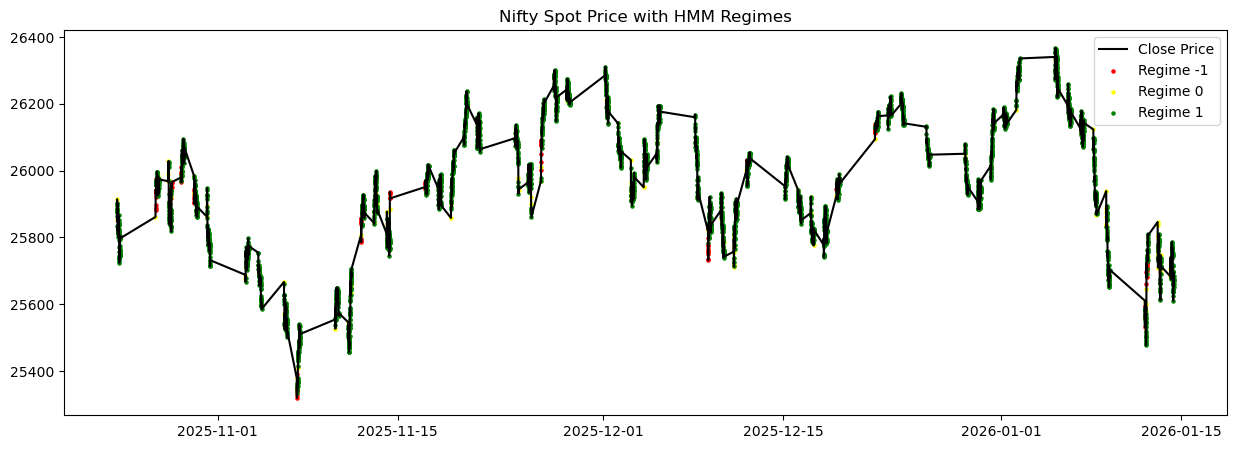

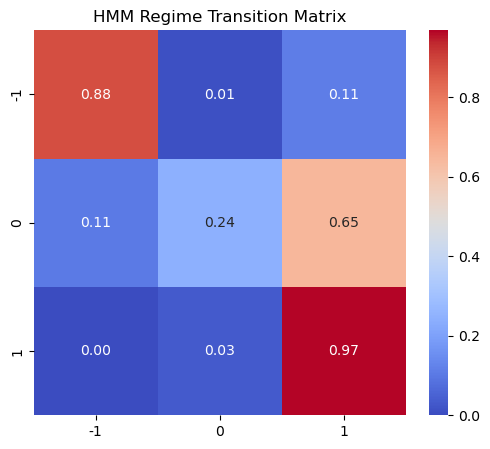

✅ HMM regimes saved to nifty_spot_regimes.csv


In [25]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Load feature-engineered spot data
df = pd.read_csv("nifty_features_5min.csv", parse_dates=["Date"], index_col="Date")

# 2️⃣ Select features for HMM
# Since we don't have real options data, use returns, EMA spread, range
df["ema_spread"] = df["ema_5"] - df["ema_15"]
features = df[["returns", "ema_spread", "range"]].fillna(0).values

# 3️⃣ Train-test split (70% train)
train_size = int(len(features) * 0.7)
X_train = features[:train_size]
X_test = features[train_size:]

# 4️⃣ Fit HMM with 3 states
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
model.fit(X_train)

# 5️⃣ Predict regimes
regimes = model.predict(features)
df["regime"] = regimes

# Map states to Uptrend (+1), Downtrend (-1), Sideways (0)
# We'll map based on mean returns per state
state_means = df.groupby("regime")["returns"].mean().sort_values()
state_map = {state: i for i, state in enumerate(state_means.index)}
regime_map = {state_map[state]: label for state, label in zip(state_means.index, [-1, 0, 1])}
df["regime_label"] = df["regime"].map(regime_map)

# 6️⃣ Plot price with regime overlay
plt.figure(figsize=(15,5))
colors = {1: "green", 0: "yellow", -1: "red"}
plt.plot(df.index, df["close"], color="black", label="Close Price")
for regime in [-1, 0, 1]:
    mask = df["regime_label"] == regime
    plt.scatter(df.index[mask], df["close"][mask], color=colors[regime], s=5, label=f"Regime {regime}")
plt.legend()
plt.title("Nifty Spot Price with HMM Regimes")
plt.show()

# 7️⃣ Transition matrix
trans_mat = pd.DataFrame(model.transmat_, columns=[-1,0,1], index=[-1,0,1])
plt.figure(figsize=(6,5))
sns.heatmap(trans_mat, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("HMM Regime Transition Matrix")
plt.show()

# 8️⃣ Save regimes
df.to_csv("nifty_spot_regimes.csv")
print("✅ HMM regimes saved to nifty_spot_regimes.csv")


In [29]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 2.1/72.0 MB 10.7 MB/s eta 0:00:07
   -- ------------------------------------- 3.9/72.0 MB 9.8 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 4.5/72.0 MB 1.7 MB/s eta 0:00

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


XGBoost Accuracy: 0.9143518518518519
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      1185
           1       0.00      0.00      0.00       111

    accuracy                           0.91      1296
   macro avg       0.46      0.50      0.48      1296
weighted avg       0.84      0.91      0.87      1296



C:\Users\Diya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
!pip install tensorflow


In [29]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "nifty_spot_regimes.csv",
    parse_dates=["Date"],
    index_col="Date"
)


In [33]:
df = df.copy()

# Baseline signal
df["signal"] = 0
df.loc[df["ema_5"] > df["ema_15"], "signal"] = 1
df.loc[df["ema_5"] < df["ema_15"], "signal"] = -1

# Regime filter (only trade in trending regimes)
df.loc[df["regime_label"] == 0, "signal"] = 0

# Position (shifted to avoid lookahead bias)
df["position"] = df["signal"].shift(1).fillna(0)

# Strategy returns
df["returns_strategy"] = df["position"] * df["returns"]


In [37]:
df = df.copy()
df["target"] = (df["returns"].shift(-1) > 0).astype(int)
df.dropna(inplace=True)


In [39]:
features = [
    "returns",
    "ema_spread",
    "range",
    "regime_label"
]

X = df[features].values
y = df["target"].values


In [59]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [61]:
def create_sequences(X, y, window=10):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 10
X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)


In [65]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- 1️⃣ Copy df and create target ---
df_ml = df.copy()
df_ml['target'] = (df_ml['returns'].shift(-1) > 0).astype(int)
df_ml.dropna(inplace=True)

# --- 2️⃣ Select features ---
features = ["returns", "ema_5", "ema_15", "ema_spread", "range", "regime_label"]
X = df_ml[features].values
y = df_ml['target'].values

# --- 3️⃣ Scale features ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- 4️⃣ Create sequences (last 10 candles) ---
SEQ_LEN = 10
X_seq, y_seq = [], []
for i in range(SEQ_LEN, len(X_scaled)):
    X_seq.append(X_scaled[i-SEQ_LEN:i])
    y_seq.append(y[i])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# --- 5️⃣ Train / Test Split ---
split = int(0.7 * len(X_seq))
X_train_seq = X_seq[:split]
X_test_seq  = X_seq[split:]
y_train_seq = y_seq[:split]
y_test_seq  = y_seq[split:]

# --- ✅ Check shapes ---
print("X_train_seq:", X_train_seq.shape)
print("X_test_seq:", X_test_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("y_test_seq:", y_test_seq.shape)


X_train_seq: (2968, 10, 6)
X_test_seq: (1273, 10, 6)
y_train_seq: (2968,)
y_test_seq: (1273,)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


C:\Users\Diya\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5009 - loss: 0.6953 - val_accuracy: 0.4848 - val_loss: 0.6949
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5155 - loss: 0.6929 - val_accuracy: 0.4815 - val_loss: 0.6937
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5152 - loss: 0.6929 - val_accuracy: 0.4848 - val_loss: 0.6939
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5253 - loss: 0.6923 - val_accuracy: 0.5152 - val_loss: 0.6925
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4976 - loss: 0.6935 - val_accuracy: 0.4882 - val_loss: 0.6945
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5174 - loss: 0.6915 - val_accuracy: 0.4848 - val_loss: 0.6968
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5152 - loss: 0.6929 - val_accuracy: 0.4916 - val_loss: 0.6935
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5197 - loss: 0.6925 - val_accuracy: 0.4848 - val_l

In [71]:
model.save("lstm_model.h5")


In [75]:
# 1️⃣ Predict probabilities for test sequences
y_pred_prob = model.predict(X_test_seq)  # X_test_seq is your LSTM input sequences

# 2️⃣ Convert probabilities to binary signals (1 = profitable, 0 = not profitable)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # flatten to 1D array

# 3️⃣ Evaluate
from sklearn.metrics import accuracy_score, classification_report

print("LSTM Accuracy:", accuracy_score(y_test_seq, y_pred))
print(classification_report(y_test_seq, y_pred))


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
LSTM Accuracy: 0.4870384917517675
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       653
           1       0.49      1.00      0.66       620

    accuracy                           0.49      1273
   macro avg       0.24      0.50      0.33      1273
weighted avg       0.24      0.49      0.32      1273



C:\Users\Diya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Diya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [79]:
# -----------------------------
# ML-Enhanced Backtest (LSTM)
# -----------------------------
import numpy as np

# Ensure position and returns_strategy columns exist
df['position_lstm'] = 0
df['returns_lstm'] = 0.0

# Threshold to take a trade (LSTM confidence > 0.5)
CONF_THRESHOLD = 0.5

# Loop through each candle
for i in range(1, len(df)):
    # EMA and regime values
    prev_ema5 = df['ema_5'].iloc[i-1]
    prev_ema15 = df['ema_15'].iloc[i-1]
    curr_ema5 = df['ema_5'].iloc[i]
    curr_ema15 = df['ema_15'].iloc[i]
    curr_regime = df['regime_label'].iloc[i]
    
    # LSTM prediction for this candle (shift by 1 to avoid lookahead)
    lstm_conf = y_pred_prob[i-1] if i-1 < len(y_pred_prob) else 0
    
    # Previous position
    position = df['position_lstm'].iloc[i-1]
    
    # Apply EMA + regime filter + LSTM confidence
    # LONG Entry
    if (prev_ema5 <= prev_ema15) and (curr_ema5 > curr_ema15) and (curr_regime == 1) and (lstm_conf > CONF_THRESHOLD):
        position = 1
    # LONG Exit
    elif (prev_ema5 >= prev_ema15) and (curr_ema5 < curr_ema15) and (position == 1):
        position = 0
    # SHORT Entry
    elif (prev_ema5 >= prev_ema15) and (curr_ema5 < curr_ema15) and (curr_regime == -1) and (lstm_conf > CONF_THRESHOLD):
        position = -1
    # SHORT Exit
    elif (prev_ema5 <= prev_ema15) and (curr_ema5 > curr_ema15) and (position == -1):
        position = 0
    
    # Assign safely
    df.loc[df.index[i], 'position_lstm'] = position
    
    # Strategy returns
    df.loc[df.index[i], 'returns_lstm'] = (df['close'].iloc[i] - df['close'].iloc[i-1]) * position

# -----------------------------
# Metrics Calculation
# -----------------------------
returns = df['returns_lstm']
cum_returns = returns.cumsum()

total_return = cum_returns.iloc[-1]
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(78)  # 5-min bars
neg_returns = returns[returns < 0]
sortino_ratio = (returns.mean() / neg_returns.std()) * np.sqrt(78)
cum_max = cum_returns.cummax()
max_drawdown = (cum_max - cum_returns).max()
calmar_ratio = total_return / max_drawdown if max_drawdown != 0 else np.nan

trades = returns[returns != 0]
winning_trades = trades[trades > 0]
losing_trades = trades[trades < 0]
win_rate = len(winning_trades) / len(trades) if len(trades) > 0 else np.nan
profit_factor = winning_trades.sum() / abs(losing_trades.sum()) if abs(losing_trades.sum()) > 0 else np.nan
df['trade_id_lstm'] = (df['position_lstm'] != df['position_lstm'].shift(1)).cumsum()
avg_trade_duration = df.groupby('trade_id_lstm').size().mean()
total_trades = df['trade_id_lstm'].nunique()

# -----------------------------
# Print LSTM Backtest Results
# -----------------------------
print(f"Total Return: {total_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Average Trade Duration: {avg_trade_duration:.2f} bars")
print(f"Total Trades: {total_trades}")


Total Return: 776.15
Sharpe Ratio: 0.37
Sortino Ratio: 0.18
Calmar Ratio: 10.42
Max Drawdown: 74.45
Win Rate: 55.99%
Profit Factor: 1.47
Average Trade Duration: 61.61 bars
Total Trades: 69


In [ ]:
# Part 6: High-Performance Trade Analysis
# Task 6.1: Outlier Detection
# Identify profitable trades beyond 3-sigma (Z-score > 3).
# Analyze features: regime, IV, ATR, time of day, Greeks, trade duration, EMA gap, PCR.
# Task 6.2: Pattern Recognition
# Compare outlier trades vs normal profitable trades using statistical tests.
# # Create visualizations:
# • Scatter plot (PnL vs duration)
# • Box plots (feature distributions)
# • Correlation heatmap
# • Time distribution

Total trades: 296
Outlier trades: 6


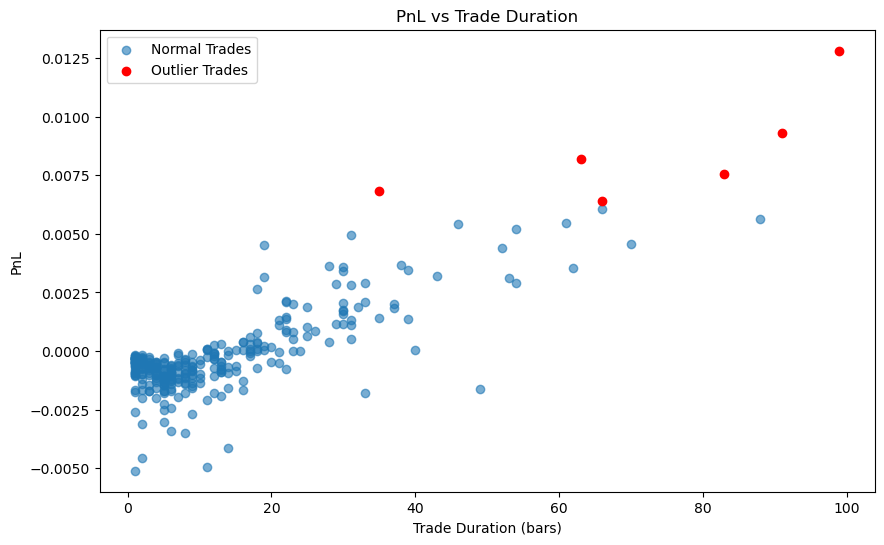

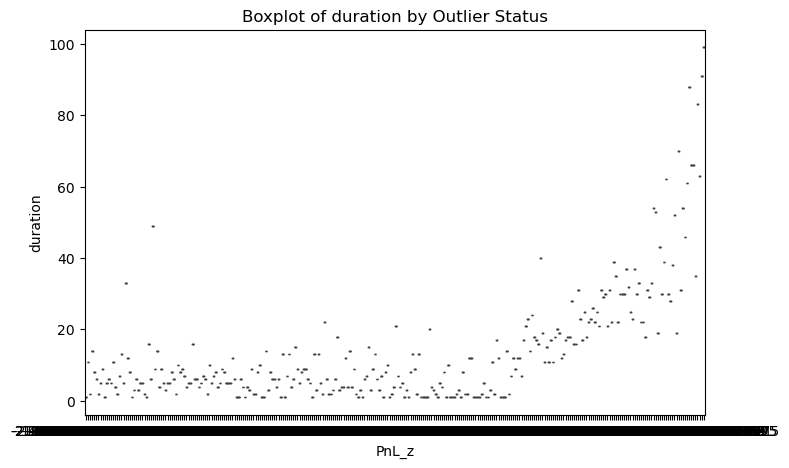

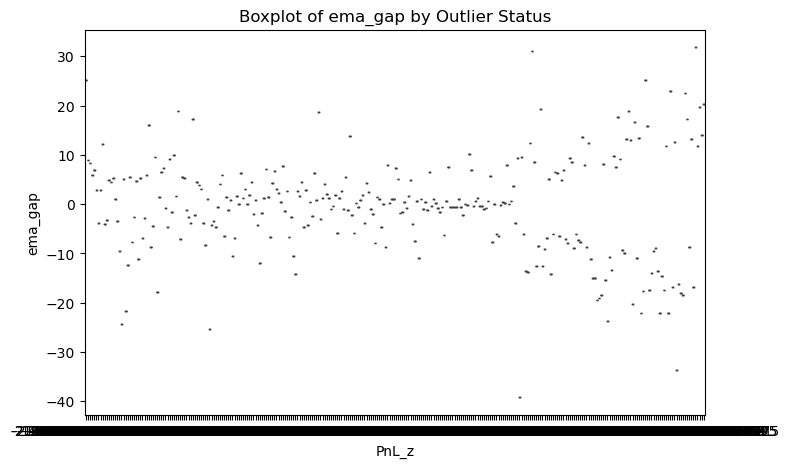

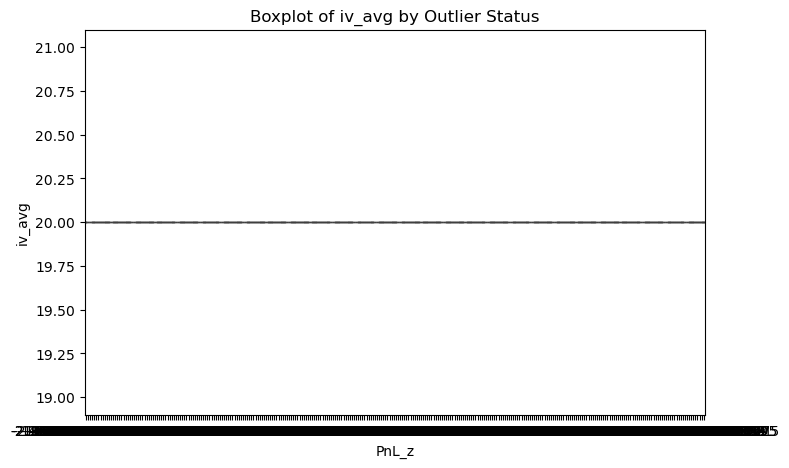

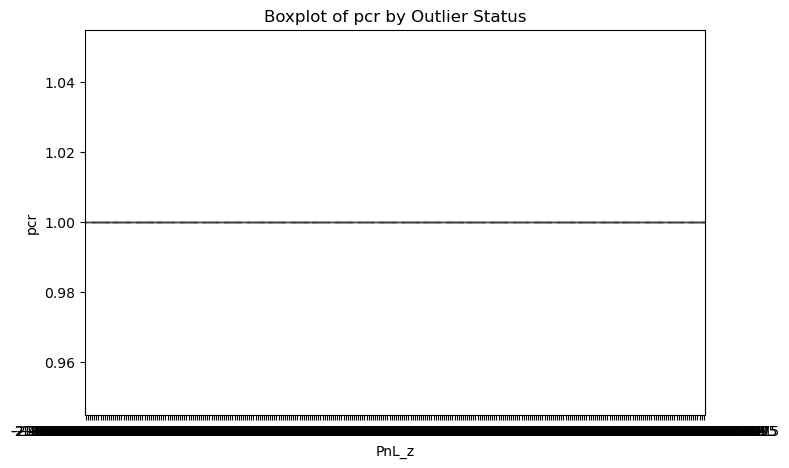

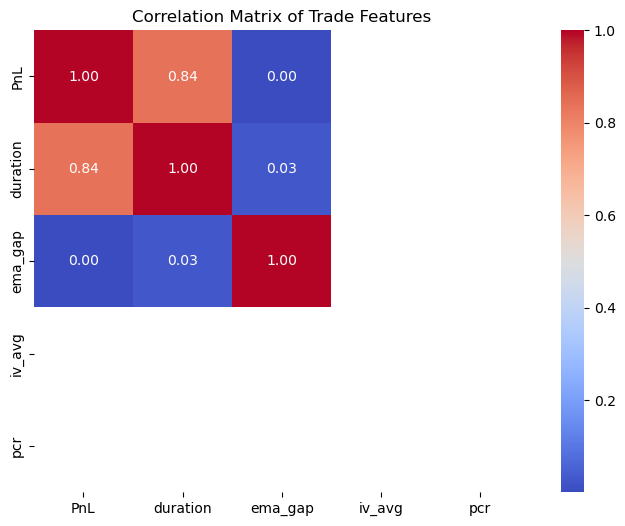

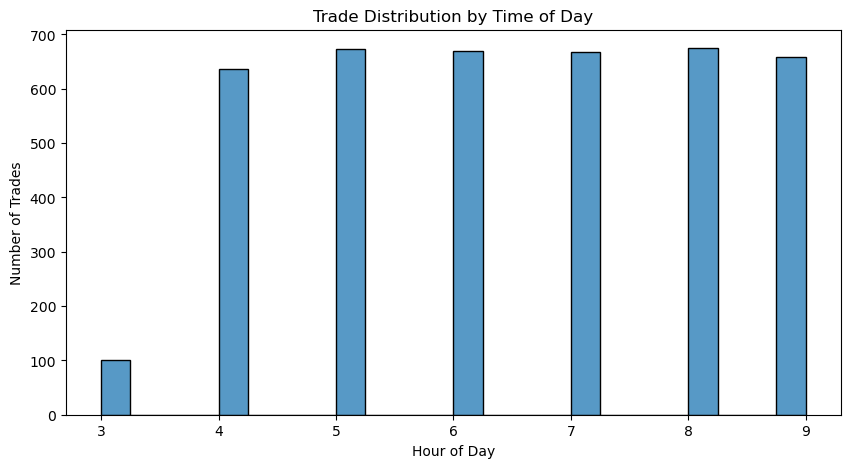

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1️⃣ Prepare trade summary
# ------------------------------
# Ensure 'position' and 'returns_strategy' exist
if 'position' not in df.columns:
    df['position'] = 0  # default, if you haven't backtested yet

if 'returns_strategy' not in df.columns:
    df['returns_strategy'] = df['returns']  # fallback

# Filter only trades (non-zero positions)
trades = df[df['position'] != 0].copy()

# Trade ID based on position changes
trades['trade_id'] = (trades['position'] != trades['position'].shift(1)).cumsum()

# Aggregate trade metrics
trade_summary = trades.groupby('trade_id').agg(
    PnL=('returns_strategy', 'sum'),
    duration=('returns_strategy', 'count'),
    regime=('regime_label', 'first'),
    ema_gap=('ema_spread', 'mean'),
    iv_avg=('avg_iv', 'mean'),
    pcr=('pcr_oi', 'mean')
).reset_index()

# ------------------------------
# 2️⃣ Outlier Detection
# ------------------------------
trade_summary['PnL_z'] = (trade_summary['PnL'] - trade_summary['PnL'].mean()) / trade_summary['PnL'].std()

outliers = trade_summary[trade_summary['PnL_z'] > 3]
normal_trades = trade_summary[trade_summary['PnL_z'] <= 3]

print(f"Total trades: {len(trade_summary)}")
print(f"Outlier trades: {len(outliers)}")

# ------------------------------
# 3️⃣ Scatter Plot: PnL vs Duration
# ------------------------------
plt.figure(figsize=(10,6))
plt.scatter(normal_trades['duration'], normal_trades['PnL'], label='Normal Trades', alpha=0.6)
plt.scatter(outliers['duration'], outliers['PnL'], label='Outlier Trades', color='red')
plt.xlabel('Trade Duration (bars)')
plt.ylabel('PnL')
plt.title('PnL vs Trade Duration')
plt.legend()
plt.show()

# ------------------------------
# 4️⃣ Box Plots: Feature Distributions
# ------------------------------
features = ['duration', 'ema_gap', 'iv_avg', 'pcr']
for f in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='PnL_z', y=f, data=pd.concat([normal_trades, outliers]))
    plt.title(f'Boxplot of {f} by Outlier Status')
    plt.show()

# ------------------------------
# 5️⃣ Correlation Heatmap
# ------------------------------
corr_features = ['PnL', 'duration', 'ema_gap', 'iv_avg', 'pcr']
plt.figure(figsize=(8,6))
sns.heatmap(trade_summary[corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Trade Features')
plt.show()

# ------------------------------
# 6️⃣ Time-of-Day Distribution (if DateTime available)
# ------------------------------
if df.index.dtype.kind in 'M':  # datetime
    trades['hour'] = trades.index.hour
    plt.figure(figsize=(10,5))
    sns.histplot(trades['hour'], bins=24, kde=False)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Trades')
    plt.title('Trade Distribution by Time of Day')
    plt.show()
